# Retail RFM analysis with python

## 1. Intro

### 1.1 About the dataset

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.

Link to the dataset: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci

### 1.2 Steps of this project

- Data cleaning and processing
- Understanding features and identifing outliar with z-score
- Building RFM metrics 
- Customer segmentation based on RFM model
- Conclusion

In [470]:
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option('display.float_format',lambda x:'%.2f' % x)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('seaborn-v0_8-pastel')
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Z-Score 
from scipy import stats

In [152]:
df = pd.read_csv('online_retail_II.csv')

## 2. Data Processing

In [6]:
df.shape

(1067371, 8)

In [144]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Checking for empty values

In [155]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [291]:
df[df.isna().any(axis=1)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales


In [158]:
df.dropna(inplace=True)

In [166]:
df.InvoiceDate.sort_values().value_counts()

2011-11-14 15:27:00    543
2011-11-28 15:54:00    534
2011-12-05 17:17:00    530
2011-11-23 13:39:00    444
2011-10-31 14:09:00    436
                      ... 
2011-01-17 15:05:00      1
2011-09-01 11:56:00      1
2010-08-20 14:54:00      1
2011-01-17 15:31:00      1
2010-05-28 11:50:00      1
Name: InvoiceDate, Length: 41439, dtype: int64

### Checking duplicates

In [160]:
df.duplicated().sum()

26479

In [164]:
df.drop_duplicates(inplace=True)

### Removing negative values

In [170]:
df.describe()

,Quantity,Price
count,797885.000000,797885.000000
mean,12.602980,3.702732
std,191.670371,71.392549
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [194]:
df.query('Quantity <= 0')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


It can be observed there are negative values in quantity and zero values in price column. For negative quantity it could be refund orders, we will remove this part as well as rows with 0 price

In [181]:
df = df.drop(df[(df['Quantity'] <= 0) | (df['Price'] == 0)].index)

### Change Data format

In [ ]:
data.dtypes

In [168]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Customer ID'] = df['Customer ID'].map(str)

### Enriching data

In [198]:
df['Sales'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
df.to_csv('retail.csv')

In [448]:
df.shape

(779425, 9)

## 3. Feature understanding

In this section , we will focus on undertanding features from three aspects:
- product
- customer
- location

### 3.1 Product

In [217]:
# Product number
print("Total number of product: ",df['Description'].nunique())

# What is the most popular product
print("The most popular product: ",df['Description'].value_counts().head(1))

# Which 5 product contributes the highst revenue
df.groupby('Description')['Sales'] \
    .agg(['count','sum']) \
    .sort_values('sum', ascending=False) \
    .head()

Total number of product:  5283
The most popular product:  WHITE HANGING HEART T-LIGHT HOLDER    5016
Name: Description, dtype: int64


,count,sum
Description,,
REGENCY CAKESTAND 3 TIER,3335,277656.25
WHITE HANGING HEART T-LIGHT HOLDER,5016,247048.01
"PAPER CRAFT , LITTLE BIRDIE",1,168469.60
Manual,681,151777.67
JUMBO BAG RED RETROSPOT,2641,134307.44


### 3.2 Customer

In [228]:
# Customer number 
print("Total number of customer: ",df['Customer ID'].nunique())

# Average orders of each customer
print("Average orders of each customer: ", df.groupby('Customer ID')['Invoice'].count().mean().round(0))

Total number of customer:  5878
Average orders of each customer:  133.0


### 3.3 Country

In [471]:
# The order distribution and sales distribution based on countries

# Calculate the sales and orders of each country
df.groupby('Country').agg({'Invoice':'count',
                            'Sales':'sum'}) \
                            .sort_values('Sales',ascending=False).head()

,Invoice,Sales
Country,,
United Kingdom,700388,14389234.92
EIRE,15565,616570.54
Netherlands,5085,554038.09
Germany,16432,425019.71
France,13511,348768.96


## 4. RFM model

### 4.1 Calculating RFM Metrics

In [279]:
# Finding out the max datetime value
df['InvoiceDate'].max()

# Using last day +2 days as the last day of our reserch period to calculate recency
end_date = dt.datetime(2011,12,11)

In [297]:
# For recency, we use the gap between the last day of research period and the latest purchase date of each customer
# For frequency, we calculate the number of orders of each customer
# For monetary, we calculate the total revenue of each customer

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (end_date - InvoiceDate.max()).days,
                                    'Invoice': lambda Invoice: Invoice.nunique(),
                                    'Sales': lambda Sales: Sales.sum()})

# Rename columns respectively
rfm.columns = ['Recency','Frequency','Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,3,8,4921.53
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


### 4.2 Remove outlier

In [281]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,5878.0,201.866791,209.353961,1.00,26.00,96.00,380.000,739.00
Frequency,5878.0,6.289384,13.009406,1.00,1.00,3.00,7.000,398.00
Monetary,5878.0,2955.904095,14440.852688,2.95,342.28,867.74,2248.305,580987.04


Recency: 


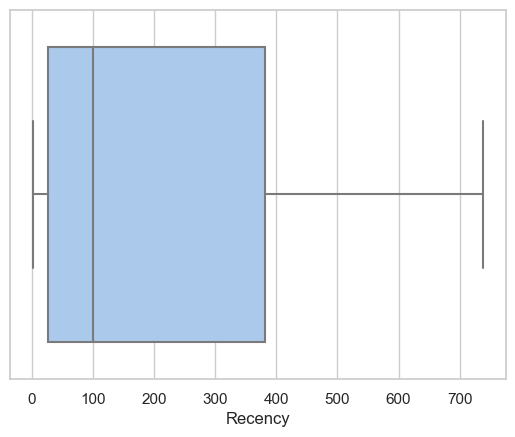

Frequency: 


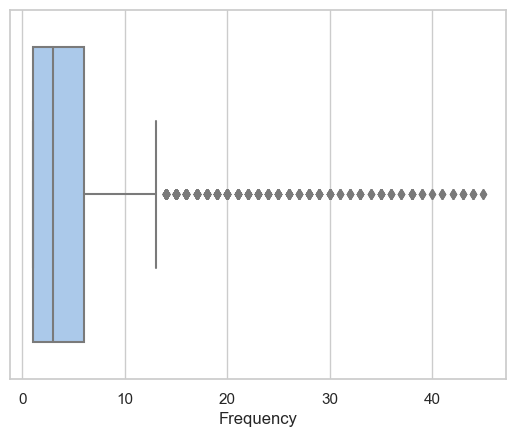

Monetary: 


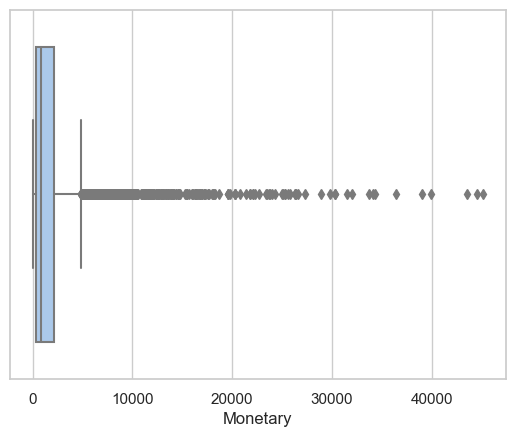

In [390]:
# To get a visual representation of outliers in the dataframe, we plot boxplot for all 3 variables
for i in rfm.columns:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm[str(i)])
    plt.show()

Observe that “recency” is the only variable with no visible outliers. “Frequency” and “monetary_value”, on the other hand, have many outliers that need to be removed before we proceed to build the model.To identify outliers, we will compute a measurement called a Z-Score. It tell us how far away from the mean a data point is.In this case we will remove the data with a Z-Score over 3, which means 3 standard deviations away from the mean value.

71 records being removed

In [307]:
# Calculate z-scores for each column
z_scores = np.abs(stats.zscore(rfm[['Recency', 'Frequency', 'Monetary']]))

# Set the threshold for identifying outliers
threshold = 3

# Find outliers based on the threshold
outlier = rfm[(z_scores > threshold).any(axis=1)]
outlier

# Remove outlier
rfm = rfm[(z_scores < 3).all(axis=1)]
rfm

,Recency,Frequency,Monetary
Customer ID,,,
12347.0,3,8,4921.53
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40
12351.0,376,1,300.93
...,...,...,...
18283.0,4,22,2664.90
18284.0,432,1,461.68
18285.0,661,1,427.00


### 4.3 Calculating RFM scores

In the RFM model, customer segmentation is typically based on three key dimensions: Recency, Frequency, and Monetary value \
For each dimensions we divided behavior into 5 bins and rank them from 1-5, while 1 refers to the poorest performance and 5 represents the best performance

In [472]:
rfm1 = rfm.copy()

rfm1['Recency_Score'] = pd.qcut(rfm1['Recency'],5,labels=[5,4,3,2,1])
rfm1['Frequency_Score'] = pd.qcut(rfm1['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
rfm1['Monetary_Score'] = pd.qcut(rfm1['Monetary'],5,labels=[1,2,3,4,5])

# Here we use R score and F score as our segment score
rfm1['RF_Score'] = rfm1['Recency_Score'].astype(str) + rfm1['Frequency_Score'].astype(str)
rfm1

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score
Customer ID,,,,,,,
12347.0,3,8,4921.53,5,4,5,54
12348.0,76,5,2019.40,3,4,4,34
12349.0,19,4,4428.69,5,3,5,53
12350.0,311,1,334.40,2,1,2,21
12351.0,376,1,300.93,2,1,2,21
...,...,...,...,...,...,...,...
18283.0,4,22,2664.90,5,5,4,55
18284.0,432,1,461.68,1,2,2,12
18285.0,661,1,427.00,1,2,2,12


## 5. Customer segmentation

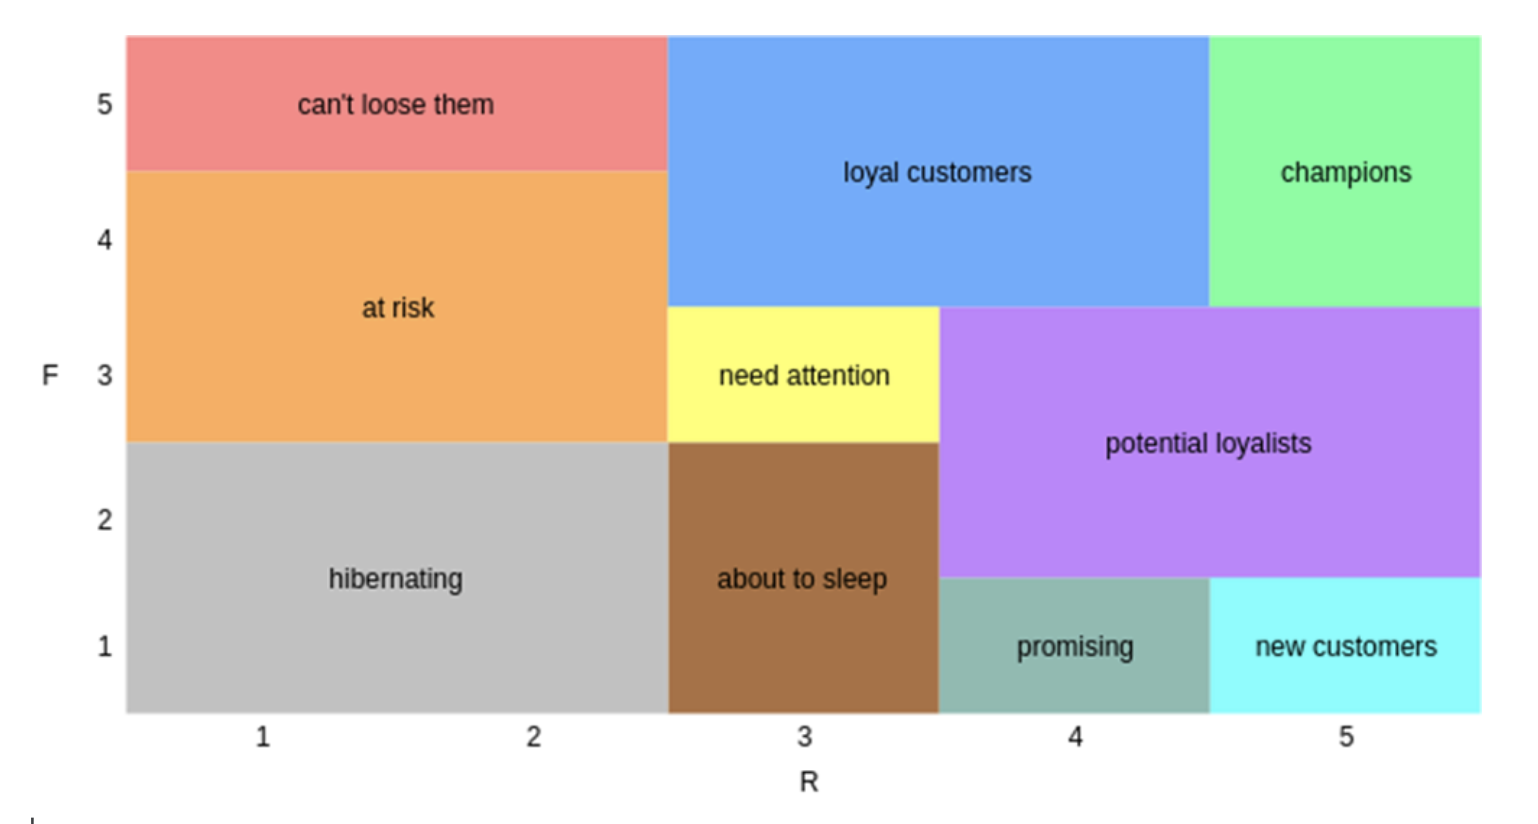

In [477]:
# Creating RFM Segments
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_risk',
           r'[1-2]5': 'cant_lose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'[5][4-5]': 'champions'}

# Mapping RFM segments to corresponding customers
rfm1['segment'] = rfm1['RF_Score'].replace(seg_map, regex=True)
rfm1.head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RF_Score,segment
Customer ID,,,,,,,,
12347.0,3,8,4921.53,5,4,5,54,champions
12348.0,76,5,2019.40,3,4,4,34,loyal_customers
12349.0,19,4,4428.69,5,3,5,53,potential_loyalists
12350.0,311,1,334.40,2,1,2,21,hibernating
12351.0,376,1,300.93,2,1,2,21,hibernating
12352.0,37,10,2849.84,4,5,5,45,loyal_customers
12353.0,205,2,406.76,2,2,2,22,hibernating
12354.0,233,1,1079.40,2,1,3,21,hibernating
12355.0,215,2,947.61,2,2,3,22,hibernating


In [478]:
rfm1[['segment','Recency','Frequency','Monetary']].groupby('segment').agg(['count','mean'])

Recency        Frequency       Monetary        
                      count   mean     count  mean    count    mean
segment                                                            
about_to_sleep          370 111.49       370  1.36      370  528.26
at_risk                 745 377.18       745  3.82      745 1325.24
cant_lose                73 339.44        73 11.89       73 4512.44
champions               832  10.00       832 13.85      832 5401.29
hibernating            1500 461.79      1500  1.24     1500  425.23
loyal_customers        1140  70.63      1140  9.27     1140 3685.45
need_attention          264 117.73       264  3.08      264 1258.57
new_customers            59  11.85        59  1.00       59  354.71
potential_loyalists     707  26.91       707  2.55      707  895.46
promising               117  41.55       117  1.00      117  335.74

### What is the proportion of each segmentation?

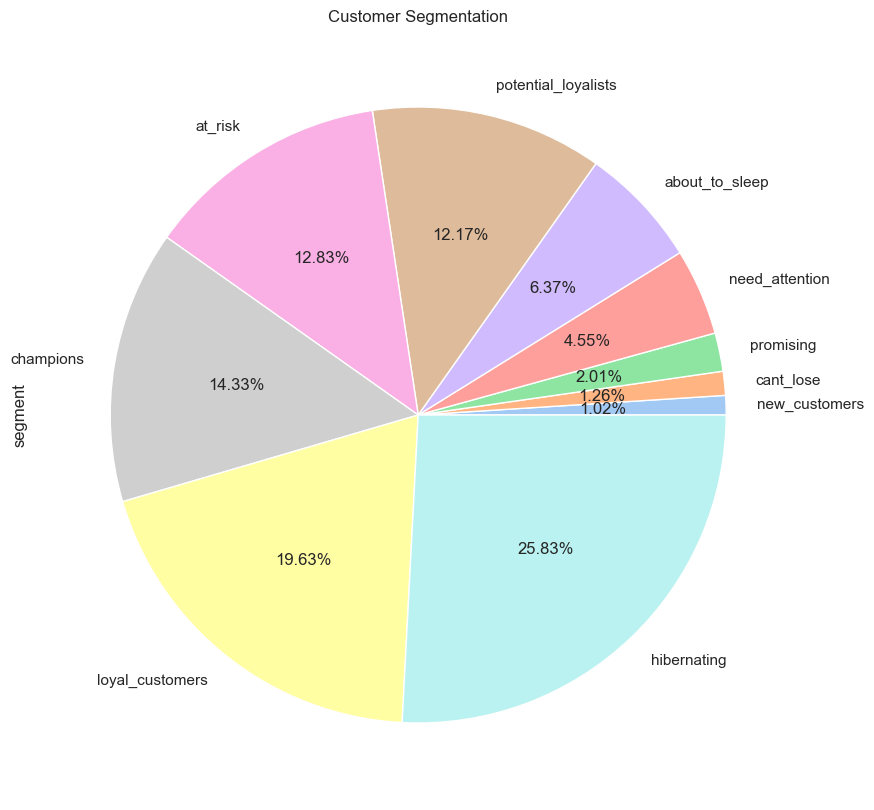

In [479]:
rfm1.groupby('segment')['segment']\
    .count()\
    .sort_values()\
    .plot(kind='pie',
        figsize = (10, 10),
        autopct = '%1.2f%%',
        title='Customer Segmentation')

plt.show()

### How much revenue does they generate

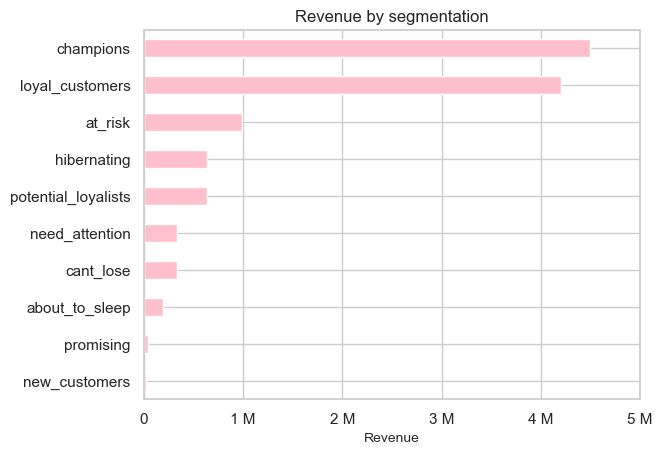

In [480]:
ax = rfm1.groupby('segment')['Monetary'] \
    .sum() \
    .sort_values() \
    .plot(kind='barh',
          title='Revenue by segmentation',
          color='pink')


ax.set_xlabel('Revenue',fontsize=10)
ax.set_ylabel('')
ax.set_xlim(0,5000000)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

### How much is the average revenue per customer in each segmentation group

The more customers, the more revenue it tends to have. To eliminate this factor, we also calculate the average revenue of each group 

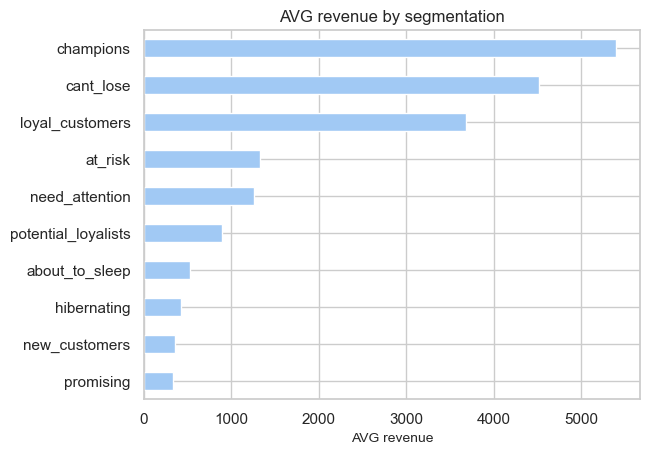

In [482]:
ax = rfm1.groupby('segment')['Monetary'] \
        .mean() \
        .sort_values() \
        .plot(kind='barh',title='AVG revenue by segmentation')


ax.set_xlabel('AVG revenue',fontsize=10)
ax.set_ylabel('')
plt.show()

## 6. Conclusion

The RFM analysis reveals distinct customer segments, each offering unique opportunities and challenges for market strategy. 
- The largest segment, 'Hibernating Customers' (26%), requires re-engagement tactics to regain interest. 
- 'Loyal Customers' (19.63%) exhibit strong engagement and loyalty, benefiting from personalized communication and loyalty programs. 
- 'Champions' (14.33%) drive the most revenue, deserving exceptional service to maintain their loyalty. 
- Acquiring 'New Customers' (1.02%) is crucial for growth, necessitating targeted marketing and enticing offers.

### Limitation of the project

In this project, customer segmentation is conducted based solely on Recency (R) and Frequency (F) dimensions, excluding Monetary (M). 
This approach aims to gauge customer loyalty. However, omitting monetary value overlooks revenue insights, limits identification of high-value customers. It may bias segmentation and lead to inperfect marketing strategies.

### Future analysis idea

Considering all three dimensions of the RFM model provides a more comprehensive understanding of customer behavior. I also did segmentations in mysql using the same dataset but calculate RFM score based on all three dimensions and in each dimension customer behaviour was divided into 4 bins. In total customers were divided into 8 groups. 

Moreover, we can also do basket analysis to see what products combination is the best, thus offer valuable insights to optimize product offerings, cross-selling strategies.